# NIFTY50 Single stocks analysis
**Notebook contains analysis and forecast on a single stock.**


Importing necessary packages

In [1]:
from os import listdir
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
sns.set_theme()
%autosave 30

Autosaving every 30 seconds


In [2]:
dft = pd.read_csv(r'C:\Users\asuto\Desktop\Work\Datasets\NIFTY50\NIFTYMASTERDATA.csv',index_col='Date',
                  parse_dates=True)
comps = dft.Symbol.unique()

## Below are the companies the model will be monitoring

In [3]:
comps

array(['ADANIPORTS', 'ASIANPAINT', 'AXISBANK', 'BAJAJ-AUTO', 'BAJAJFINSV',
       'BAJFINANCE', 'BHARTIARTL', 'BPCL', 'BRITANNIA', 'CIPLA',
       'COALINDIA', 'DRREDDY', 'EICHERMOT', 'GAIL', 'GRASIM', 'HCLTECH',
       'HDFC', 'HDFCBANK', 'HEROMOTOCO', 'HINDALCO', 'HINDUNILVR',
       'ICICIBANK', 'INDUSINDBK', 'INFY', 'IOC', 'ITC', 'JSWSTEEL',
       'KOTAKBANK', 'LT', 'MARUTI', 'MM', 'NESTLEIND', 'NTPC', 'ONGC',
       'POWERGRID', 'RELIANCE', 'SBIN', 'SHREECEM', 'SUNPHARMA',
       'TATAMOTORS', 'TATASTEEL', 'TCS', 'TECHM', 'TITAN', 'ULTRACEMCO',
       'UPL', 'VEDL', 'WIPRO', 'ZEEL'], dtype=object)

In [4]:
comp30 = ['INFY','TCS','RELIANCE','ICICIBANK','HDFC','HCLTECH','BHARTIARTL',
          'INDUSINDBK','SBIN','LT','TECHM','MM','AXISBANK','ITC','BAJAJ-AUTO','ONGC',
          'TATASTEEL','NTPC','TECHM','ASIANPAINT','POWERGRID','BAJAJFINSV','TITAN','NESTLEIND',
          'ULTRACEMCO','MARUTI','HDFCBANK','HINDUNILVR','SUNPHARMA','KOTAKBANK'  
         ]
len(comp30)

30

## Various columns and the dataframe itself

In [5]:
cols = ['Symbol','Prev Close', 'Open', 'High', 'Low','Close' ,'Last','Volume', 'Turnover']
dft

,Symbol,Prev Close,Open,High,Low,Close,Last,Volume,Turnover
Date,,,,,,,,,
2010-11-04,ADANIPORTS,159.90,161.0,163.00,160.30,161.20,161.05,835546,1.348395e+13
2010-11-05,ADANIPORTS,161.20,163.0,163.00,161.60,162.30,162.35,187158,3.037435e+12
2010-11-08,ADANIPORTS,162.30,162.5,163.45,160.20,161.40,161.30,613082,9.911300e+12
2010-11-09,ADANIPORTS,161.40,162.5,165.00,161.35,162.25,162.40,601933,9.825511e+12
2010-11-10,ADANIPORTS,162.25,162.5,162.90,159.55,159.90,160.00,423032,6.795621e+12
...,...,...,...,...,...,...,...,...,...
2021-04-26,ZEEL,188.00,190.6,191.10,185.10,186.40,186.70,8542755,1.600451e+14
2021-04-27,ZEEL,186.40,188.0,192.95,186.80,188.15,188.80,14247767,2.698636e+14
2021-04-28,ZEEL,188.15,188.8,190.60,187.10,189.10,188.95,8429439,1.591917e+14


## Get Data Function

In [36]:
def get_data(stock,feature):
    return dft[dft.Symbol == stock][feature]

## Indicators
**Indicators play an important role in representing the status of a stock in the market. They at times provide more information than just the stock price itself.**

We will pick few of the most important indicators for the project.

- **Simple Moving Average**
- **Exponential Moving Average**

In [53]:
def generate_data(stock,feature,slow=26,fast=12,smooth=9,lookback=14):
    op = get_data(stock,'Open') # Open
    cl = get_data(stock,'Close')
    diff = cl-op # Daily Difference
    ewa1 = op.ewm(span=slow,min_periods=0,adjust=False).mean()
    datf = ewa1.diff() # Consecutive Day Difference
    ewa2 = op.ewm(span=fast,min_periods=0,adjust=False).mean()
    macd = ewa2-ewa1
    signal = macd.ewm(span=smooth,min_periods=0,adjust=False).mean().values
    hist = macd - signal # MACD Difference
    
    datf = op.diff()
    up = []
    down = []
    for i in range(len(datf)):
        if datf[i] < 0:
            up.append(0)
            down.append(datf[i])
        else:
            up.append(datf[i])
            down.append(0)
            
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs)) # RSI
    #rsi.dropna(inplace=True)
    #rsi.fillna()
    #rsi.interpolate(limit_direction ='backward',methoh = 'linear',inplace=True)
    
    final = {'stock':op.values,'diff':diff.values,'cdiff':datf.values,
             'macd':hist.values,'rsi':rsi.values
            }
    
    df = pd.DataFrame(final)
    df.set_index(op.index,inplace=True)
    df.interpolate(limit_direction ='backward',methoh = 'linear',inplace=True)
    
    return df
    

In [54]:
generate_data('ZEEL','Open')

,stock,diff,cdiff,macd,rsi
Date,,,,,
2010-11-04,292.00,5.40,7.85,0.000000,100.000000
2010-11-05,299.85,-3.80,7.85,0.500969,100.000000
2010-11-08,296.05,-0.30,-3.80,0.545056,96.410014
2010-11-09,296.50,-1.15,0.45,0.570450,96.426375
2010-11-10,295.90,-0.80,-0.60,0.514487,95.799460
...,...,...,...,...,...
2021-04-26,190.60,-4.20,-1.40,-0.192343,40.093194
2021-04-27,188.00,0.15,-2.60,-0.231689,38.096103
2021-04-28,188.80,0.30,0.80,-0.142965,39.101266


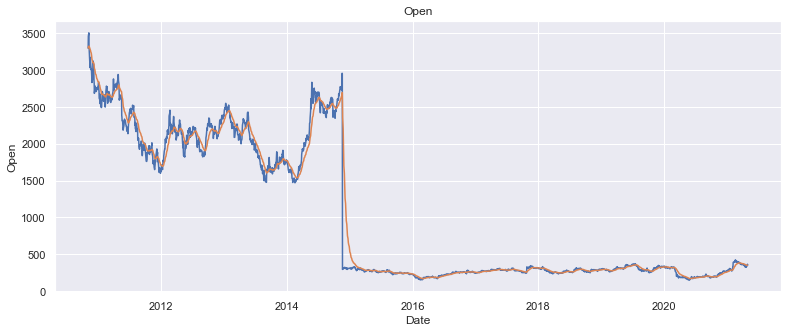

In [39]:
def plotstock(stock,feature='Open'):         
    plt.figure(figsize=(13,5))
    dat = dft[dft.Symbol == stock]
    
    if type(feature) == type([]):
        for i in feature:
            sns.lineplot(data = dat[i])
        
    else:
        sns.lineplot(data = dat[feature])
        datrol = dat[feature].rolling(window =30).mean()
        datrol = dat[feature].ewm(span=26,min_periods=0,adjust=False,ignore_na=False).mean()
        sns.lineplot(data = datrol)
    plt.title(feature)
    return

feature = 'Close'
stock = np.random.choice(comps)
plotstock(stock=stock,feature='Open')

    

Since most of the stock market believes heavily on **Exponential Moving Average**, we too will by deafult will work with **EMA**.

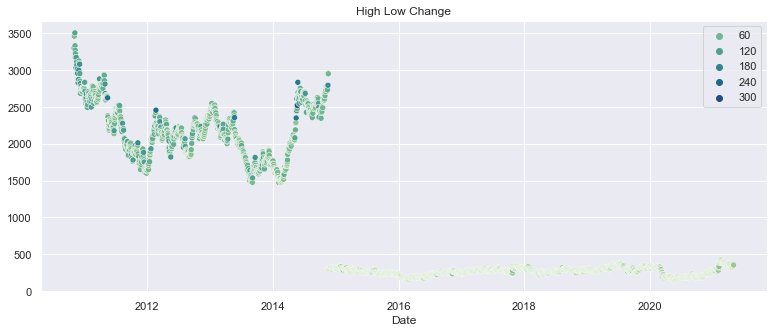

In [40]:
def dailychange(stock,strategy = 'openclose',standalone=True):
    if strategy == 'openclose':
        op = get_data(stock,'Open')
        cl = get_data(stock,'Close')
        diff = cl-op
        title = 'Open Close Change'
    else:
        hi = get_data(stock,'High')
        lo = get_data(stock,'Low')
        diff = hi-lo
        title = 'High Low Change'
        
    plt.figure(figsize=(13,5)) 
    dat = get_data(stock,'Open')
    if standalone:
        #sns.scatterplot(data = data,x = data.index,y = 'Open',hue=diff,palette='crest')
        sns.lineplot(data = diff)
        plt.title(title)
    else:
        sns.scatterplot(data = dat,x = dat.index,y = dat.values,hue=diff,palette='crest')
        plt.title(title)
    plt.plot()
    return

dailychange(stock,strategy='k',standalone=False)        
    

* **Differential Change**
* **Percentage Change**

These indicators are performed only on Exponential Weighted Average of the stock information.

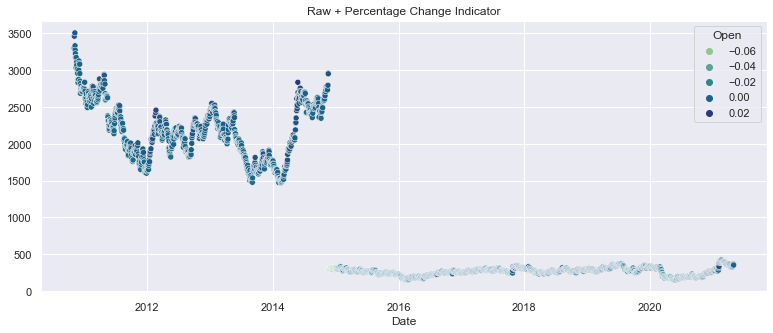

In [41]:
def change(data,strategy='diff',standalone = True):
    datrol = data.ewm(span=26,min_periods=0,adjust=False,ignore_na=False).mean()
    if strategy == 'diff':
        datf = datrol.diff()
        title = 'Differential Indicator'
    else:
        datf = datrol.pct_change()
        title = 'Percentage Change Indicator'
        
    datf.fillna(0,inplace=True)
    plt.figure(figsize=(13,5)) 
    if standalone:
        sns.scatterplot(data = datrol,x = datrol.index,y = datrol.values,hue=datf,palette='crest')
        plt.title("EWA + "+title)
    else:
        sns.scatterplot(data = data,x = data.index,y = data.values,hue=datf,palette='crest')
        plt.title("Raw + " + title)
    plt.plot()
    return


data = get_data(stock,'Open')
change(data,strategy='pct',standalone=False)
        
    

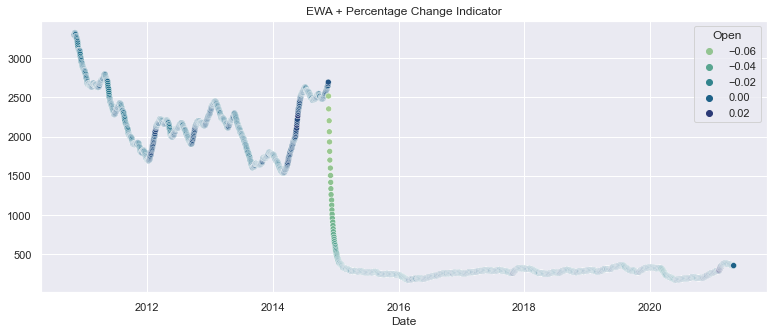

In [42]:
change(data,strategy='pct')

- **MACD**

**Moving average convergence divergence (MACD)** is a trend-following momentum indicator that shows the relationship between two moving averages of a stock’s price. 

The MACD is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA.

In [43]:
def indicator_macd(data,slow=26,fast=12,smooth=9):
    #SLOW
    ewa1 = data.ewm(span=slow,min_periods=0,adjust=False).mean()
    #FAST
    ewa2 = data.ewm(span=fast,min_periods=0,adjust=False).mean()
    
    macd = ewa2-ewa1
    
    signal = macd.ewm(span=smooth,min_periods=0,adjust=False).mean().values
    
    hist = macd - signal
    
    ret = {'slow':ewa1.values,'fast':ewa2.values,'macd':macd.values,
           'signal':signal,
           'histogram':hist.values,'time':data.index}
    
    return pd.DataFrame(ret,index=ret['time'])
    

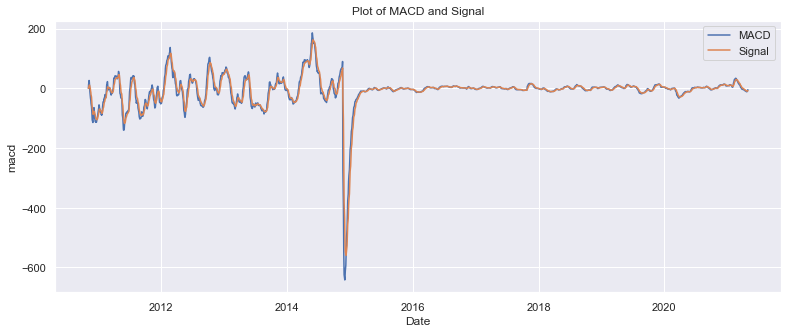

In [44]:
def plot_macd(data,feature='macd',standalone = True):
    ret = indicator_macd(data)
    plt.figure(figsize=(13,5)) 
    if standalone == True:
        sns.lineplot(data = ret,x = ret.index,y = 'macd',label = 'MACD')
        sns.lineplot(data = ret,x = ret.index,y = 'signal',label = 'Signal')
        title = "Plot of MACD and Signal"
    else:        
        sns.scatterplot(x = data.index,y = data, hue=ret[feature],palette='crest')
        title = 'Plot of MACD on the data'
    plt.title(title)
    plt.plot()
    return ret


_ = plot_macd(data,feature='histogram',standalone=True)

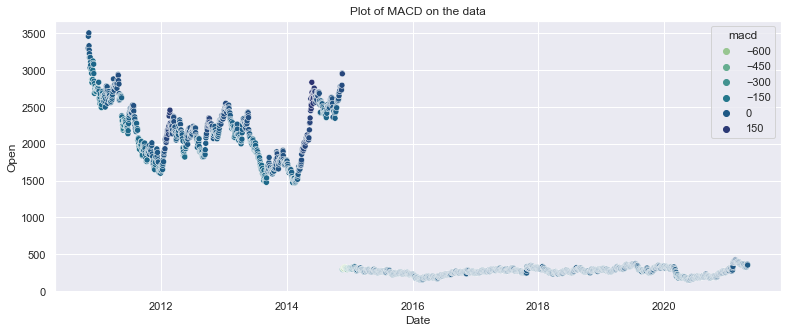

In [45]:
_ = plot_macd(data,standalone=False)

- **RSI**

The **Relative Strength Index (RSI)** is a momentum indicator that evaluates overbought or oversold conditions by measuring the magnitude of recent price changes for various assets. 

In [46]:
def indicator_rsi(data, lookback=14):
    ret = data.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
            
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    #rsi.dropna(inplace=True)
    #rsi.fillna()
    #rsi.interpolate(limit_direction ='backward',methoh = 'linear',inplace=True)
    return rsi


tt = indicator_rsi(data)


In [52]:
tt

0              NaN
1       100.000000
2       100.000000
3        91.902700
4        89.277979
           ...    
2593     43.137013
2594     45.917243
2595     52.729290
2596     56.371155
2597     50.340978
Length: 2598, dtype: float64

In [47]:
len(tt),len(data)

(2598, 2598)

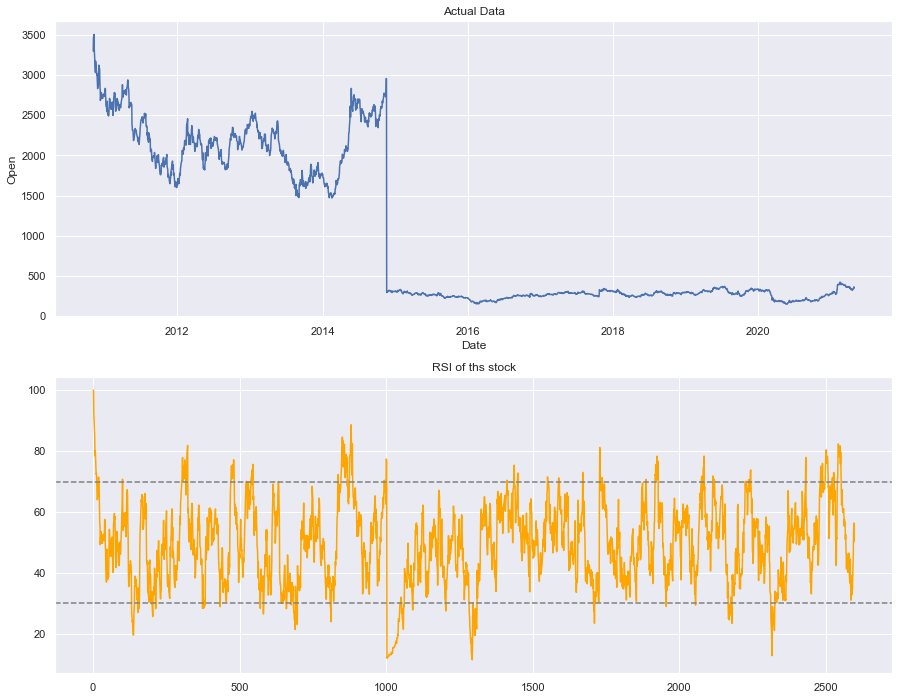

In [50]:
def plot_rsi(data,standalone = True):
    ret = indicator_rsi(data)
    if standalone == True:
        fig, ax = plt.subplots(2, 1, figsize=(15,12))
        sns.lineplot(data = data,ax=ax[0])
        ax[0].set_title("Actual Data")
        sns.lineplot(data = ret,ax=ax[1],color = 'orange')
        ax[1].axhline(30, linestyle = '--', linewidth = 1.5, color = 'grey')
        ax[1].axhline(70, linestyle = '--', linewidth = 1.5, color = 'grey')
        ax[1].set_title("RSI of ths stock")
    else:    
        plt.figure(figsize = (13,5))
        sns.scatterplot(data = data,x = data.index, y = data.values,hue=ret,palette='crest')
        plt.title('RSI Index on actual data')
    plt.plot()
    return ret

tt= plot_rsi(data,standalone=True)

In [51]:
tt

0              NaN
1       100.000000
2       100.000000
3        91.902700
4        89.277979
           ...    
2593     43.137013
2594     45.917243
2595     52.729290
2596     56.371155
2597     50.340978
Length: 2598, dtype: float64

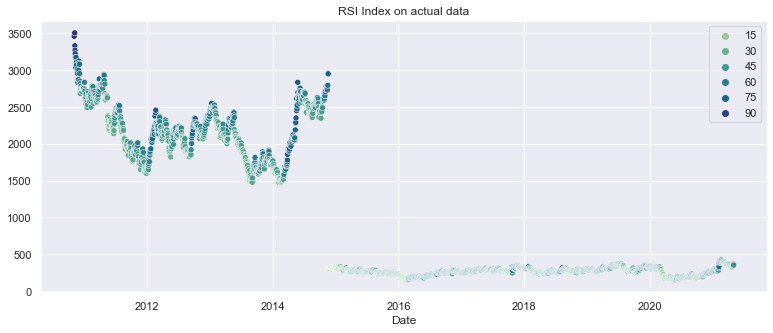

In [49]:
_= plot_rsi(data,standalone=False)

**The above indicators are vital for understanding the stock market and will be used in our model development.**
